In [5]:
import datasets
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import operator
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

dataset_to_times = {
    "wmt_lm_year": list(range(2012, 2017)),
    "wmt_lm_month": [f"{year}_{month}" for year in range(2012, 2017) for month in range(12)],
    "poli_aff": list(range(2015, 2021)),
    "news_sum": list(range(2012, 2017)),
}

dataset_to_path = {
    "wmt_lm_year": "KaiNylund/WMT-year-splits",
    "wmt_lm_month": "KaiNylund/WMT-month-splits",
    "poli_aff_train": "/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/", # Replace
    "news_sum_train": "/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/newsroom/summarization/train/", # Replace
    "poli_aff_test": "/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/test/", #train/indivs/", # Replace
    "news_sum_test": "/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/newsroom/summarization/test/" #train/", # Replace
}


In [ ]:
dataset_to_split_vocabs = defaultdict(dict)
#dataset_to_split_vocabs = np.load("./dataset_vocabs.npy", allow_pickle=True).item()
for dataset_name in ["wmt_lm_year", "wmt_lm_month"]:
    for overall_split in ["train", "test"]:
        dataset_times = dataset_to_times[dataset_name]
        dataset_path = dataset_to_path[dataset_name]
        hf_dataset = datasets.load_dataset(dataset_path)
        for time in dataset_times:
            print(time)
            if f"{time}_{overall_split}" in hf_dataset:
                all_tokens = []
                def update_tokens(example):
                    global all_tokens
                    all_tokens += example["text"].split(" ")
                    return example
                hf_dataset[f"{time}_{overall_split}"].map(update_tokens, load_from_cache_file=False)
                dataset_to_split_vocabs[f"{dataset_name}_{overall_split}"][time] = Counter(all_tokens)
            else:
                print("missing: " + str(time))

np.save("./data/dataset_vocabs", dataset_to_split_vocabs)

In [10]:
for dataset_name in ["poli_aff", "news_sum"]:
    for overall_split in ["train", "test"]:
        dataset_times = dataset_to_times[dataset_name]
        dataset_path = dataset_to_path[f"{dataset_name}_{overall_split}"]
        for time in dataset_times:
            print(f"{dataset_path}{time}.jsonl")
            pd_dataset = pd.read_json(f"{dataset_path}{time}.jsonl", lines=True)
            all_tokens = []
            def update_tokens(example):
                global all_tokens
                all_tokens += example["text"].split(" ")
                return example
            pd_dataset.apply(update_tokens, axis=1)
            dataset_to_split_vocabs[f"{dataset_name}_{overall_split}"][time] = Counter(all_tokens)

np.save("./data/dataset_vocabs", dataset_to_split_vocabs)

/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/2015.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/2016.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/2017.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/2018.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/2019.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/train/indivs/2020.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/test/2015.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/test/2016.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/test/2017.jsonl
/mmfs1/gscratch/ark/knylund/breaking-news-benchmark/tasks/datasets/poli_tweets/test/2018.jsonl
/m

In [11]:
print(dataset_to_split_vocabs.keys())
print(dataset_to_split_vocabs["wmt_lm_month_test"].keys())

dict_keys(['wmt_lm_year_train', 'wmt_lm_year_test', 'wmt_lm_month_train', 'wmt_lm_month_test', 'poli_aff_train', 'poli_aff_test', 'news_sum_train', 'news_sum_test'])
dict_keys(['2012_0', '2012_1', '2012_2', '2012_3', '2012_4', '2012_5', '2012_6', '2012_8', '2012_9', '2012_10', '2012_11', '2013_0', '2013_1', '2013_2', '2013_3', '2013_4', '2013_5', '2013_6', '2013_7', '2013_8', '2013_9', '2013_10', '2013_11', '2014_0', '2014_1', '2014_2', '2014_3', '2014_4', '2014_5', '2014_6', '2014_7', '2014_8', '2014_9', '2014_10', '2014_11', '2015_0', '2015_1', '2015_2', '2015_3', '2015_4', '2015_5', '2015_6', '2015_7', '2015_8', '2015_9', '2015_10', '2015_11', '2016_0', '2016_1', '2016_2', '2016_3', '2016_4', '2016_6', '2016_7', '2016_8', '2016_9', '2016_10', '2016_11'])


In [13]:
# Measure train/train and test/test vocab overlaps
dataset_to_split_vocabs = np.load("./data/dataset_vocabs.npy", allow_pickle=True).item()
dataset_to_vocab_overlap_pcts = {}
for dataset_name, split_to_token_counts in dataset_to_split_vocabs.items():
    dataset_times = list(split_to_token_counts.keys())
    times_vocab_overlap = np.empty((len(dataset_times), len(dataset_times)))
    times_vocab_overlap.fill(np.nan)
    time_to_top_10k = {}
    for i, (time, token_counts) in tqdm(enumerate(split_to_token_counts.items())):
        sorted_token_counts = sorted(token_counts.items(), key=operator.itemgetter(1))[::-1]
        time_to_top_10k[time] = set([c[0] for c in sorted_token_counts[:10000]])
    for i, time1 in enumerate(dataset_times):
        for j, time2 in enumerate(dataset_times):
            shared_vocab = time_to_top_10k[time1].intersection(time_to_top_10k[time2])
            times_vocab_overlap[i][j] = len(shared_vocab) / 10000
    print(dataset_name, times_vocab_overlap)
    dataset_to_vocab_overlap_pcts[dataset_name] = times_vocab_overlap
np.save("./data/dataset_top10k_vocab_overlap_pcts", dataset_to_vocab_overlap_pcts)


5it [00:01,  2.93it/s]


wmt_lm_year_train [[1.     0.9168 0.8994 0.8905 0.8923]
 [0.9168 1.     0.934  0.9226 0.9121]
 [0.8994 0.934  1.     0.9363 0.9211]
 [0.8905 0.9226 0.9363 1.     0.9331]
 [0.8923 0.9121 0.9211 0.9331 1.    ]]


5it [00:00, 11.95it/s]


wmt_lm_year_test [[1.     0.8188 0.8055 0.8056 0.8038]
 [0.8188 1.     0.8214 0.8206 0.8134]
 [0.8055 0.8214 1.     0.8248 0.8119]
 [0.8056 0.8206 0.8248 1.     0.8222]
 [0.8038 0.8134 0.8119 0.8222 1.    ]]


58it [00:06,  8.93it/s]


wmt_lm_month_train [[1.     0.8775 0.8724 ... 0.8237 0.8313 0.8317]
 [0.8775 1.     0.8752 ... 0.8212 0.8292 0.8254]
 [0.8724 0.8752 1.     ... 0.8331 0.8363 0.833 ]
 ...
 [0.8237 0.8212 0.8331 ... 1.     0.8804 0.8722]
 [0.8313 0.8292 0.8363 ... 0.8804 1.     0.8821]
 [0.8317 0.8254 0.833  ... 0.8722 0.8821 1.    ]]


58it [00:01, 38.76it/s]


wmt_lm_month_test [[1.     0.7003 0.7025 ... 0.6771 0.6805 0.679 ]
 [0.7003 1.     0.6987 ... 0.6702 0.6745 0.6687]
 [0.7025 0.6987 1.     ... 0.6805 0.683  0.681 ]
 ...
 [0.6771 0.6702 0.6805 ... 1.     0.6997 0.6992]
 [0.6805 0.6745 0.683  ... 0.6997 1.     0.7027]
 [0.679  0.6687 0.681  ... 0.6992 0.7027 1.    ]]


6it [00:00, 71.06it/s]


poli_aff_train [[1.     0.5458 0.5147 0.4956 0.487  0.4676]
 [0.5458 1.     0.5476 0.5214 0.5022 0.483 ]
 [0.5147 0.5476 1.     0.5708 0.5421 0.5153]
 [0.4956 0.5214 0.5708 1.     0.5841 0.5532]
 [0.487  0.5022 0.5421 0.5841 1.     0.5676]
 [0.4676 0.483  0.5153 0.5532 0.5676 1.    ]]


6it [00:00, 309.51it/s]


poli_aff_test [[0.9189 0.2869 0.2716 0.2656 0.2618 0.2516]
 [0.2869 0.9609 0.2818 0.2722 0.2711 0.2575]
 [0.2716 0.2818 0.9562 0.2889 0.2844 0.2697]
 [0.2656 0.2722 0.2889 0.9902 0.3019 0.284 ]
 [0.2618 0.2711 0.2844 0.3019 1.     0.2979]
 [0.2516 0.2575 0.2697 0.284  0.2979 0.9929]]


5it [00:01,  4.00it/s]


news_sum_train [[1.     0.8949 0.8643 0.77   0.8157]
 [0.8949 1.     0.8823 0.772  0.8181]
 [0.8643 0.8823 1.     0.792  0.8351]
 [0.77   0.772  0.792  1.     0.7847]
 [0.8157 0.8181 0.8351 0.7847 1.    ]]


5it [00:00, 14.78it/s]

news_sum_test [[1.     0.7919 0.7772 0.6997 0.7323]
 [0.7919 1.     0.7812 0.7016 0.7271]
 [0.7772 0.7812 1.     0.7179 0.7447]
 [0.6997 0.7016 0.7179 1.     0.6946]
 [0.7323 0.7271 0.7447 0.6946 1.    ]]


In [4]:
# Measure train/test vocab overlaps
dataset_to_split_vocabs = np.load("./data/dataset_vocabs.npy", allow_pickle=True).item()
dataset_to_vocab_overlap_pcts = np.load("./data/dataset_top10k_vocab_overlap_pcts.npy", allow_pickle=True).item()
for dataset_name, dataset_times in dataset_to_times.items():
    times_vocab_overlap = np.empty((len(dataset_times), len(dataset_times)))
    times_vocab_overlap.fill(np.nan)
    time_to_top_10k = {}
    for overall_split in ["train", "test"]:
        for i, (time, token_counts) in tqdm(enumerate(dataset_to_split_vocabs[f"{dataset_name}_{overall_split}"].items())):
            sorted_token_counts = sorted(token_counts.items(), key=operator.itemgetter(1))[::-1]
            time_to_top_10k[f"{time}_{overall_split}"] = set([c[0] for c in sorted_token_counts[:10000]])
    for i, time1 in enumerate(dataset_times):
        for j, time2 in enumerate(dataset_times):
            if f"{time1}_train" in time_to_top_10k and f"{time2}_test" in time_to_top_10k:
                shared_vocab = time_to_top_10k[f"{time1}_train"].intersection(time_to_top_10k[f"{time2}_test"])
                times_vocab_overlap[i][j] = len(shared_vocab) / 10000
    print(dataset_name, times_vocab_overlap)
    dataset_to_vocab_overlap_pcts[f"{dataset_name}_train_test"] = times_vocab_overlap
np.save("./data/dataset_top10k_vocab_overlap_pcts", dataset_to_vocab_overlap_pcts)

5it [00:01,  4.73it/s]
5it [00:00, 25.39it/s]


wmt_lm_year [[0.8879 0.8534 0.8363 0.8404 0.8417]
 [0.8625 0.8845 0.8599 0.8617 0.8554]
 [0.8508 0.8677 0.8743 0.8689 0.8607]
 [0.8455 0.8603 0.8591 0.8799 0.864 ]
 [0.8434 0.8524 0.8513 0.866  0.8761]]


58it [00:03, 16.02it/s]
58it [00:00, 60.90it/s]


wmt_lm_month [[0.7858 0.7701 0.7731 ... 0.7402 0.7445 0.7375]
 [0.7684 0.7839 0.7758 ... 0.7337 0.7402 0.7367]
 [0.7649 0.7663 0.7946 ... 0.7427 0.7452 0.7396]
 ...
 [0.7374 0.7333 0.7453 ... 0.7849 0.7707 0.7656]
 [0.7398 0.7352 0.747  ... 0.7764 0.7814 0.77  ]
 [0.7394 0.735  0.7471 ... 0.7676 0.7684 0.7807]]


6it [00:00, 123.19it/s]
6it [00:00, 358.64it/s]


poli_aff [[0.4693 0.3846 0.3625 0.3506 0.3524 0.3343]
 [0.38   0.4375 0.3789 0.3664 0.3585 0.3438]
 [0.3645 0.3839 0.4294 0.3939 0.3842 0.3608]
 [0.354  0.3691 0.3941 0.4359 0.4072 0.38  ]
 [0.3477 0.3542 0.3739 0.4042 0.4399 0.3905]
 [0.3372 0.3458 0.3639 0.3877 0.4084 0.4325]]


5it [00:00,  6.93it/s]
5it [00:00, 31.81it/s]

news_sum [[0.8654 0.8327 0.8086 0.7235 0.7625]
 [0.8375 0.862  0.8201 0.7238 0.7626]
 [0.8166 0.8239 0.855  0.7416 0.7743]
 [0.7387 0.7437 0.764  0.8433 0.7398]
 [0.7774 0.7774 0.7903 0.732  0.8347]]


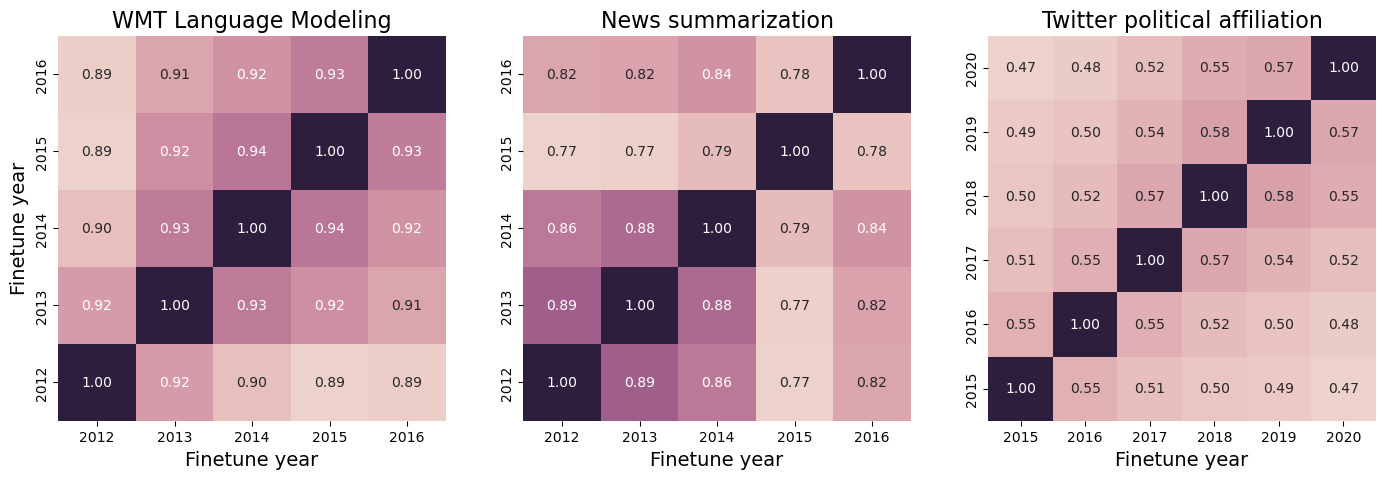

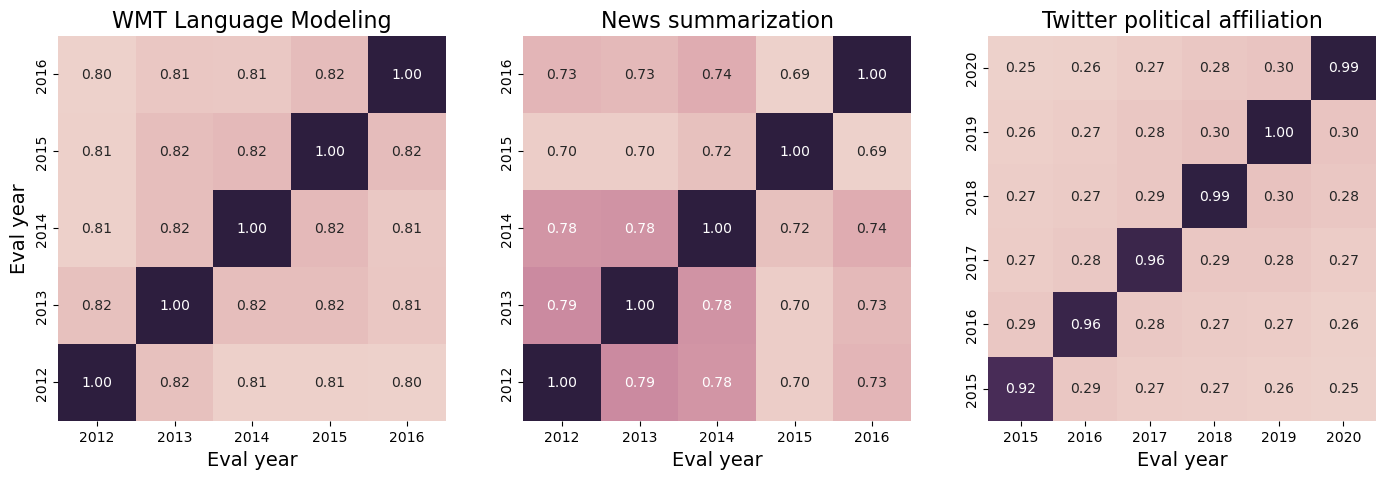

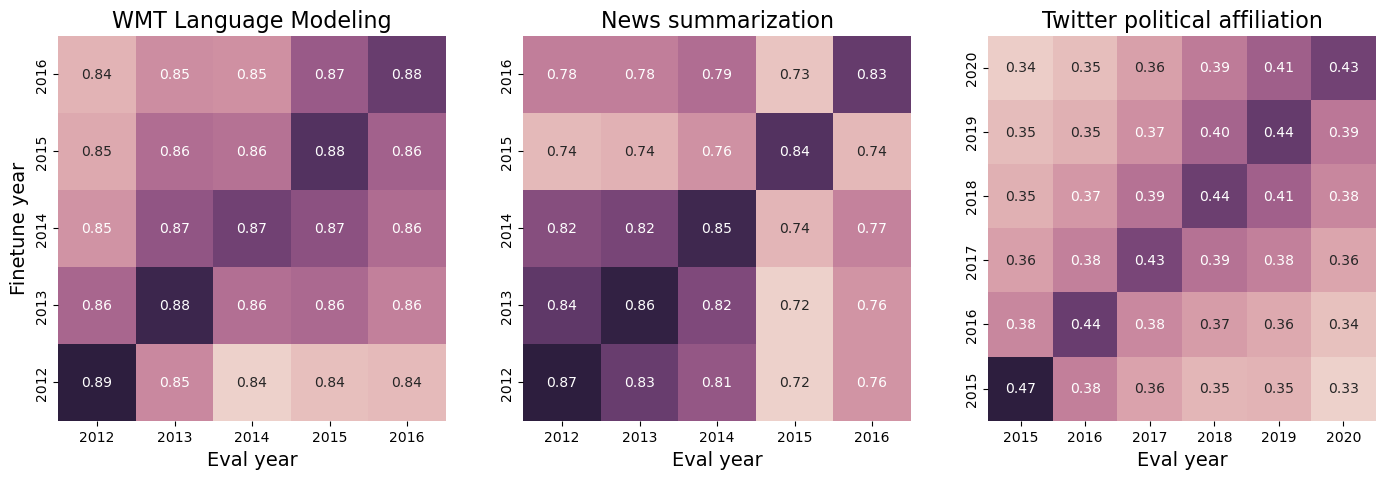

In [13]:
dataset_to_vocab_overlap_pcts = np.load("./data/dataset_top10k_vocab_overlap_pcts.npy", allow_pickle=True).item()
for overall_split in ["train", "test", "train_test"]:
    fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    axs = axs.flatten()

    cmap=sns.cubehelix_palette(as_cmap=True)

    ax = sns.heatmap(dataset_to_vocab_overlap_pcts[f"wmt_lm_year_{overall_split}"], ax=axs[0], annot=True, fmt=".2f",
                    cmap=cmap, cbar_kws={'label': 'Vocab overlap (%)'}, cbar=False)
    ax.invert_yaxis()
    ax.set_title("WMT Language Modeling", fontsize=16)
    if overall_split == "train":
        ax.set_ylabel("Finetune year", fontsize=14)
        ax.set_xlabel("Finetune year", fontsize=14)
    elif overall_split == "test":
        ax.set_ylabel("Eval year", fontsize=14)
        ax.set_xlabel("Eval year", fontsize=14)
    else:
        ax.set_ylabel("Finetune year", fontsize=14)
        ax.set_xlabel("Eval year", fontsize=14)
    ax.set_yticklabels(list(range(2012, 2017)))
    ax.set_xticklabels(list(range(2012, 2017)))

    ax = sns.heatmap(dataset_to_vocab_overlap_pcts[f"news_sum_{overall_split}"], ax=axs[1], annot=True, fmt=".2f",
                    cmap=cmap, cbar_kws={'label': 'Vocab overlap (%)'}, cbar=False)
    ax.invert_yaxis()
    ax.set_title("News summarization", fontsize=16)
    if overall_split == "train":
        ax.set_xlabel("Finetune year", fontsize=14)
    else:
        ax.set_xlabel("Eval year", fontsize=14)
    ax.set_yticklabels(list(range(2012, 2017)))
    ax.set_xticklabels(list(range(2012, 2017)))

    ax = sns.heatmap(dataset_to_vocab_overlap_pcts[f"poli_aff_{overall_split}"], ax=axs[2], annot=True, fmt=".2f",
                    cmap=cmap, cbar_kws={'label': 'Vocab overlap (%)'}, cbar=False)
    ax.invert_yaxis()
    ax.set_title("Twitter political affiliation", fontsize=16)
    if overall_split == "train":
        ax.set_xlabel("Finetune year", fontsize=14)
    else:
        ax.set_xlabel("Eval year", fontsize=14)
    ax.yaxis.set_tick_params(labelsize = 10)
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.set_yticklabels(list(range(2015, 2021)))
    ax.set_xticklabels(list(range(2015, 2021)))
    plt.show()

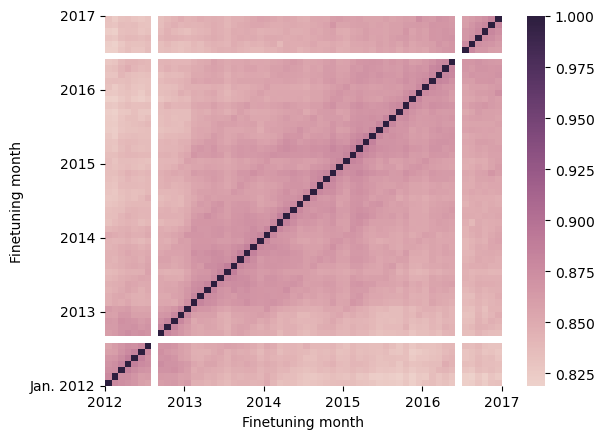

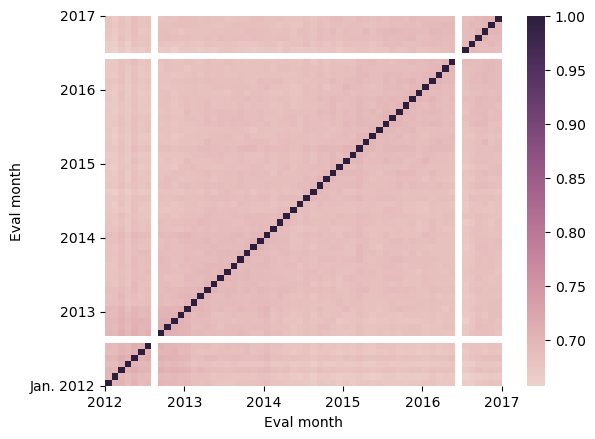

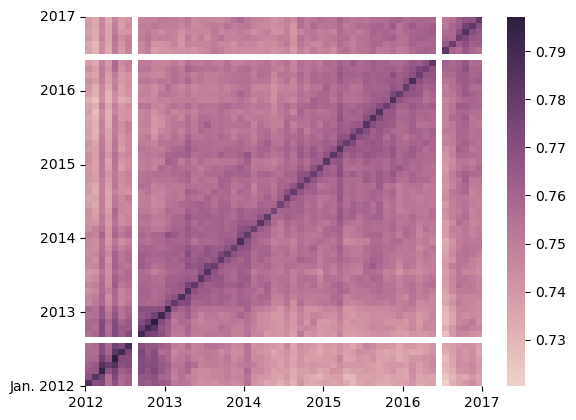

In [15]:
for overall_split in ["train", "test", "train_test"]:
    cur_month_heatmap = deepcopy(dataset_to_vocab_overlap_pcts[f"wmt_lm_month_{overall_split}"])
    if overall_split != "train_test":
        cur_month_heatmap = np.insert(cur_month_heatmap, 7, np.full(58, np.nan), axis=0)
        cur_month_heatmap = np.insert(cur_month_heatmap, 7, np.full(59, np.nan), axis=1)
        cur_month_heatmap = np.insert(cur_month_heatmap, 53, np.full(59, np.nan), axis=0)
        cur_month_heatmap = np.insert(cur_month_heatmap, 53, np.full(60, np.nan), axis=1)
    sns.heatmap(cur_month_heatmap, cmap=cmap)
    plt.gca().invert_yaxis()
    ticks = list(range(0, 61, 12))
    tick_labels = list(range(2012, 2018))
    plt.xticks(ticks=ticks, labels=tick_labels, rotation='horizontal')
    tick_labels[0] = "Jan. 2012"
    plt.yticks(ticks=ticks, labels=tick_labels, rotation='horizontal')
    if overall_split == "train":
        plt.ylabel("Finetuning month")
        plt.xlabel("Finetuning month")
    if overall_split == "test":
        plt.ylabel("Eval month")
        plt.xlabel("Eval month")
    plt.show()